In [13]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

from recommenders import knn_recommender

# Read Pokemon Data

In [2]:
pokemon_dict = {}
# with open('pokemon.json', 'r') as file:
with open('50-pokemon.json', 'r') as file:
    pokemon_dict = json.load(file)

In [3]:
full_pokemon_df = pd.json_normalize(pokemon_dict['pokemon'])
desired_cols = ['abilities', 'height', 'name', 'stats', 'types', 'weight']
pokemon_df = full_pokemon_df[desired_cols]
pokemon_df

,abilities,height,name,stats,types,weight
0,"[{'ability': {'name': 'overgrow', 'url': 'http...",7,bulbasaur,"[{'base_stat': 45, 'effort': 0, 'stat': {'name...","[{'slot': 1, 'type': {'name': 'grass', 'url': ...",69
1,"[{'ability': {'name': 'overgrow', 'url': 'http...",10,ivysaur,"[{'base_stat': 60, 'effort': 0, 'stat': {'name...","[{'slot': 1, 'type': {'name': 'grass', 'url': ...",130
2,"[{'ability': {'name': 'overgrow', 'url': 'http...",20,venusaur,"[{'base_stat': 80, 'effort': 0, 'stat': {'name...","[{'slot': 1, 'type': {'name': 'grass', 'url': ...",1000
3,"[{'ability': {'name': 'blaze', 'url': 'https:/...",6,charmander,"[{'base_stat': 39, 'effort': 0, 'stat': {'name...","[{'slot': 1, 'type': {'name': 'fire', 'url': '...",85
4,"[{'ability': {'name': 'blaze', 'url': 'https:/...",11,charmeleon,"[{'base_stat': 58, 'effort': 0, 'stat': {'name...","[{'slot': 1, 'type': {'name': 'fire', 'url': '...",190
5,"[{'ability': {'name': 'blaze', 'url': 'https:/...",17,charizard,"[{'base_stat': 78, 'effort': 0, 'stat': {'name...","[{'slot': 1, 'type': {'name': 'fire', 'url': '...",905
6,"[{'ability': {'name': 'torrent', 'url': 'https...",5,squirtle,"[{'base_stat': 44, 'effort': 0, 'stat': {'name...","[{'slot': 1, 'type': {'name': 'water', 'url': ...",90
7,"[{'ability': {'name': 'torrent', 'url': 'https...",10,wartortle,"[{'base_stat': 59, 'effort': 0, 'stat': {'name...","[{'slot': 1, 'type': {'name': 'water', 'url': ...",225
8,"[{'ability': {'name': 'torrent', 'url': 'https...",16,blastoise,"[{'base_stat': 79, 'effort': 0, 'stat': {'name...","[{'slot': 1, 'type': {'name': 'water', 'url': ...",855
9,"[{'ability': {'name': 'shield-dust', 'url': 'h...",3,caterpie,"[{'base_stat': 45, 'effort': 1, 'stat': {'name...","[{'slot': 1, 'type': {'name': 'bug', 'url': 'h...",29


# Format Pokemon Data

In [4]:
abilities = pokemon_df['abilities'].values
formatted_abilities = list(map(lambda list_val: {'ability {}'.format(i): list_val[i]['ability']['name'] if i < len(list_val) else None for i in range(3)}, abilities))
abilities_df = pd.DataFrame.from_dict(formatted_abilities)
abilities_df

,ability 0,ability 1,ability 2
0,overgrow,chlorophyll,None
1,overgrow,chlorophyll,None
2,overgrow,chlorophyll,None
3,blaze,solar-power,None
4,blaze,solar-power,None
5,blaze,solar-power,None
6,torrent,rain-dish,None
7,torrent,rain-dish,None
8,torrent,rain-dish,None
9,shield-dust,run-away,None


In [5]:
stats = pokemon_df['stats'].values
formatted_stats = list(map(lambda list_val: {stat['stat']['name']: stat['base_stat'] for i, stat in enumerate(list_val)}, stats))
stats_df = pd.DataFrame.from_dict(formatted_stats)
stats_df

,hp,attack,defense,special-attack,special-defense,speed
0,45,49,49,65,65,45
1,60,62,63,80,80,60
2,80,82,83,100,100,80
3,39,52,43,60,50,65
4,58,64,58,80,65,80
5,78,84,78,109,85,100
6,44,48,65,50,64,43
7,59,63,80,65,80,58
8,79,83,100,85,105,78
9,45,30,35,20,20,45


In [6]:
types = pokemon_df['types'].values
formatted_types = list(map(lambda list_val: {'type {}'.format(i): list_val[i]['type']['name'] if i < len(list_val) else None for i in range(2)}, types))
types_df = pd.DataFrame.from_dict(formatted_types)
types_df

,type 0,type 1
0,grass,poison
1,grass,poison
2,grass,poison
3,fire,None
4,fire,None
5,fire,flying
6,water,None
7,water,None
8,water,None
9,bug,None


In [7]:
pokemon_df = pd.concat([pokemon_df, abilities_df, stats_df, types_df], axis=1).drop(['abilities', 'stats', 'types'], axis=1)
pokemon_df

,height,name,weight,ability 0,ability 1,ability 2,hp,attack,defense,special-attack,special-defense,speed,type 0,type 1
0,7,bulbasaur,69,overgrow,chlorophyll,None,45,49,49,65,65,45,grass,poison
1,10,ivysaur,130,overgrow,chlorophyll,None,60,62,63,80,80,60,grass,poison
2,20,venusaur,1000,overgrow,chlorophyll,None,80,82,83,100,100,80,grass,poison
3,6,charmander,85,blaze,solar-power,None,39,52,43,60,50,65,fire,None
4,11,charmeleon,190,blaze,solar-power,None,58,64,58,80,65,80,fire,None
5,17,charizard,905,blaze,solar-power,None,78,84,78,109,85,100,fire,flying
6,5,squirtle,90,torrent,rain-dish,None,44,48,65,50,64,43,water,None
7,10,wartortle,225,torrent,rain-dish,None,59,63,80,65,80,58,water,None
8,16,blastoise,855,torrent,rain-dish,None,79,83,100,85,105,78,water,None
9,3,caterpie,29,shield-dust,run-away,None,45,30,35,20,20,45,bug,None


# Recommenders

The following recommender uses K-Nearest Neighbors, using raw Pokemon stats as data

In [8]:
knn = knn_recommender()
knn.create(pokemon_df)

Based on this model, Charizard is similar to Venusaur, Ninetails, Nidoking, Venomoth, and Raichu

In [9]:
distances, indices = knn.recommend('charizard')
for i in indices:
    print(knn.get_pokemon(i))

5     charizard
2      venusaur
37    ninetales
33     nidoking
48     venomoth
25       raichu
Name: name, dtype: object


The following recommender again uses K-Nearest Neighbors, but using the distribution of Pokemon stats instead

In [10]:
knn_prop = knn_recommender()
knn_prop.create(pokemon_df, proportions=True)

As predicted, the Pokemon most similar to Charizard include the Charmander family line

In [11]:
distances, indices = knn_prop.recommend('charizard')
for i in indices:
    print(knn_prop.get_pokemon(i))

5      charizard
4     charmeleon
48      venomoth
3     charmander
2       venusaur
1        ivysaur
Name: name, dtype: object


The intention of this project is to determine unexpectedly similar Pokemon. One example of this is how similar (stat-wise) Charizard and Venomoth are, having similar raw stats and also a similar distribution.

Text(0.5, 0, 'Base Stat')

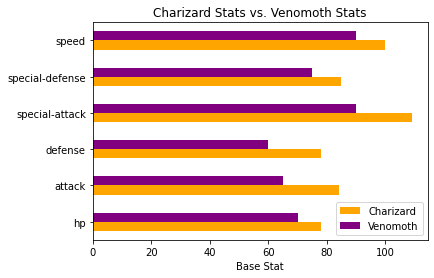

In [48]:
char_veno_df = pokemon_df[(pokemon_df['name'] == 'charizard') | (pokemon_df['name'] == 'venomoth')]
char_veno_stats = char_veno_df[['name', 'hp', 'attack', 'defense', 'special-attack', 'special-defense', 'speed']]
charizard_stats = char_veno_stats.drop(['name'], axis=1).iloc[0].values
venomoth_stats = char_veno_stats.drop(['name'], axis=1).iloc[1].values
plot_df = pd.DataFrame({'Charizard': charizard_stats, 'Venomoth': venomoth_stats}, index=['hp', 'attack', 'defense', 'special-attack', 'special-defense', 'speed'])
stat_plot = plot_df.plot(kind="barh", title="Charizard Stats vs. Venomoth Stats",
        color={"orange", "purple"})
stat_plot.set_xlabel('Base Stat')

Text(0.5, 0, 'Proportion of Total Stat')

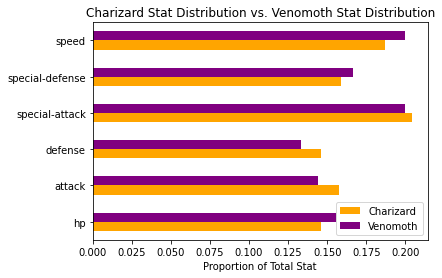

In [49]:
charizard_prop = char_veno_stats.drop(['name'], axis=1).iloc[0].values
charizard_prop = charizard_prop / sum(charizard_prop)
venomoth_prop = char_veno_stats.drop(['name'], axis=1).iloc[1].values
venomoth_prop = venomoth_prop / sum(venomoth_prop)
plot_prop_df = pd.DataFrame({'Charizard': charizard_prop, 'Venomoth': venomoth_prop}, index=['hp', 'attack', 'defense', 'special-attack', 'special-defense', 'speed'])
stat_prop_plot = plot_prop_df.plot(kind="barh", title="Charizard Stat Distribution vs. Venomoth Stat Distribution",
        color={"orange", "purple"})
stat_prop_plot.set_xlabel('Proportion of Total Stat')